In [1]:
%matplotlib inline

import autolens as al
import autolens.plot as aplt
import numpy as np
import matplotlib.pyplot as plt

from time import perf_counter as clock

from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
from astropy.constants import G, M_sun, c
import astropy.units as u

from pyprojroot import here

workspace_path = str(here())
print("Workspace Path: ", workspace_path)

Workspace Path:  /home/carlos/Documents/GitHub/Master-Degree


In [2]:
#Reading and defining data of simulation
#All values are stored in the original jam_axi_rms_example.py and in the text files present in this folder
#To know: mge.txt; other_parameters.txt; vrm.txt


surf_lum, sigma_lum, qobs_lum = np.loadtxt("mge.txt", unpack=True)         #Reading data of MGE
inc_dat = 60.
mbh_dat = 1e8 * u.solMass
ML_dat = 1.2 * (u.solMass/u.solLum)
distance_dat = 16.5 * u.Mpc

In [3]:
#Lens parameters


z = z_at_value(cosmo.angular_diameter_distance, distance_dat, zmax=1.0) #Convert distance to redshifth 
z_lens = z                                    #Lens redshifth
z_source = 2.1                                #Source redshift

#Angular diameter distances
D_l = cosmo.angular_diameter_distance(z_lens)                       
D_s = cosmo.angular_diameter_distance(z_source)
D_ls = cosmo.angular_diameter_distance_z1z2(z_lens, z_source)

#Useful constants
metre2Mpc = (1*u.m).to(u.Mpc)/u.m           #Constant factor to convert metre to Mpc.
kg2Msun = (1*u.kg/M_sun)*u.solMass/u.kg     #Constant factor to convert kg to Msun

G_Mpc = G*(metre2Mpc)**3/kg2Msun            #Gravitational constant in Mpc³/(Msun s²)
c_Mpc = c*metre2Mpc                         #Speed of light in Mpc/s


In [4]:
#Lens mass parameters for simulation

#Galaxy
distance_sim = D_l         #Angular diameter distance [Mpc]
inc_sim = inc_dat          #Inclination [deg]
mbh_sim =  mbh_dat         #Mass of black hole [M_sun]
ML_sim = ML_dat

In [5]:
#Stars
surf_lum_sim = surf_lum * (u.solLum/u.pc**2)               #Surface luminosity Density in L_sun/pc²
sigma_lum_sim_ARC = sigma_lum * u.arcsec                   #Sigma in arcsec
sigma_lum_sim_PC = (sigma_lum_sim_ARC*D_l).to(u.pc, u.dimensionless_angles()) #Convert sigma in arcsec to sigma in pc
qobs_lum_sim = qobs_lum                                        #axial ratio of star photometry

In [6]:
# Pyautolens Model

#Convert  surf_lum_sim to total mass per Guassian
Lum_star_dat = 2*np.pi*surf_lum_sim*(sigma_lum_sim_PC**2)*qobs_lum_sim    #Total luminosity per gaussian component in L_sun

#Update the stellar mass based on M/L.
Mass_lum_sim = Lum_star_dat*ML_sim                                   #Total star mass per gaussian in M_sun

#Inserting a Gaussian to represent SMBH at the center of the galaxy
sigmaBH_ARC = 0.01*u.arcsec
"""
        This scalar gives the sigma in arcsec of the Gaussian representing the
        central black hole of mass MBH (See Section 3.1.2 of `Cappellari 2008.
        <http://adsabs.harvard.edu/abs/2008MNRAS.390...71C>`_)
        The gravitational potential is indistinguishable from a point source
        for ``radii > 2*RBH``, so the default ``RBH=0.01`` arcsec is appropriate
        in most current situations.

        ``RBH`` should not be decreased unless actually needed!
"""


sigmaBH_PC = (sigmaBH_ARC*D_l).to(u.pc, u.dimensionless_angles())        #Sigma of the SMBH in pc
surfBH_PC = mbh_sim/(2*np.pi*sigmaBH_PC**2)                              #Mass surface density of SMBH
qSMBH = 1.                                                               #Assuming a circular gaussian
Mass_mbh_sim = 2*np.pi*surfBH_PC*(sigmaBH_PC**2)*qSMBH                   #SMBH Total mass 

#Defining the general inputs for the model
Total_Mass = np.concatenate((Mass_lum_sim, Mass_mbh_sim), axis=None)       #Mass per gaussian component in M_sun
Total_q = np.concatenate((qobs_lum_sim, qSMBH), axis=None)                 #Total axial ratio per gaussian


Total_sigma_ARC = np.concatenate((sigma_lum_sim_ARC, sigmaBH_ARC), axis=None)  #Total sigma per gaussian in arcsec
Total_sigma_RAD = Total_sigma_ARC.to(u.rad)                    #Total sigma per gaussian in radians

To simulate an image, we need to model the telescope’s optics. We’ll do this by convolving the image with a Point-Spread Function using a Kernel object, which we can simulate as a Gaussian. We also simulated a grid


In [7]:
psf = al.Kernel.from_gaussian(shape_2d=(11, 11), sigma=0.1, pixel_scales=0.1)

grid = al.Grid.uniform(shape_2d=(85, 85), pixel_scales=0.1, sub_size=1)

Now, lets setup our lens galaxy, source galaxy and Tracer.

In [8]:
# __Defining the MGE mass model__
#Initializing the MGE model for the lens

mass_profile = al.mp.MGE(centre=(0.0, 0.0))                                #Mass model
mass_profile.MGE_comps(M=Total_Mass.value, sigma=Total_sigma_RAD.value,
                       q=Total_q, z_l=z_lens, z_s=z_source)               #Input parameters

mass_profile.MGE_Grid_parameters(grid)
shear_comp = al.convert.shear_elliptical_comps_from(magnitude=0.02, phi=142) #external shear

lens_galaxy = al.Galaxy(
    redshift=z_lens,
    mass=mass_profile,
    shear=al.mp.ExternalShear(elliptical_comps=shear_comp)
)

In [9]:
#Source galaxy
source_galaxy = al.Galaxy(
    redshift=z_source,
    bulge=al.lp.EllipticalSersic(
        centre=(0, 0.8),
        elliptical_comps=(0.3, 0.111111),
        intensity=5.0,
        effective_radius=0.5,
        sersic_index=0.8,
    ),
)

In [10]:
#Tracing the deflection angles
tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

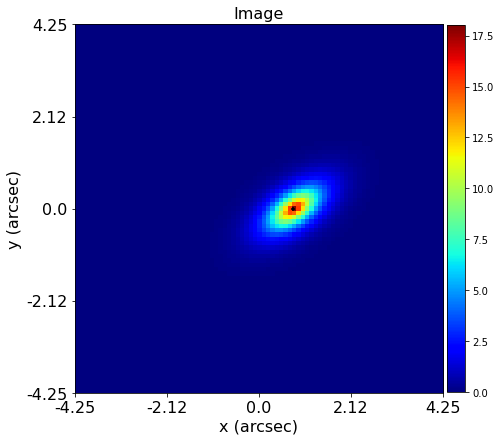

In [11]:
#Ploting our source galaxy
plotter = aplt.Plotter(
    figure=aplt.Figure(figsize=(7, 7)),
    ticks=aplt.Ticks(ysize=5, xsize=8),
    labels=aplt.Labels(ysize=12, xsize=12, titlesize=12),
)
#output=aplt.Output(filename="Souce_galaxy.fits", format="fits")
aplt.Galaxy.image(galaxy=source_galaxy, grid=grid)

Lets look at the Tracer’s image - this is the image we’ll be simulating.

Entrou
MainProcess 8.776917934417725
Critical curve could not be calculated due to an unphysical mass model


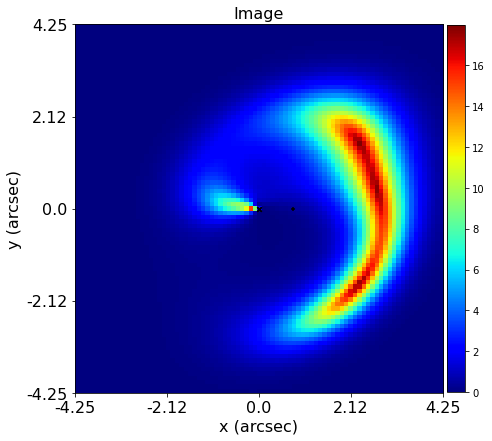

8.988259065999955


In [12]:
time = clock()
aplt.Tracer.image(tracer=tracer, grid=grid)
print(clock() - time)

To Simulate the Imaging data, we don’t use the image plotted above. Instead, we use an image which has been generated specifically for simulating an image, which pads the array it is computed on based on the shape of the PSF we convolve the image with. This ensures edge-effects do not degrade our simulation’s PSF convolution

In [13]:
time = clock()

normal_image = tracer.image_from_grid(grid=grid)
padded_image = tracer.padded_image_from_grid_and_psf_shape(
    grid=grid, psf_shape_2d=psf.shape_2d
)
print(normal_image.shape)
print(padded_image.shape)

print(clock() - time)

Entrou
MainProcess 8.688555240631104
Entrou
MainProcess 10.84830093383789
(7225,)
(9025,)
20.029563107000286


Now, to simulate the Imaging data, we pass the Tracer and Grid to the Imaging module’s simulate function. This adds the following effects to the image:


    Telescope optics: Using the Point Spread Function above.
    The Background Sky: Although the image that is returned is automatically background sky subtracted.
    Poisson noise: Due to the background sky, lens galaxy and source galaxy Poisson photon counts.


In [14]:
time = clock()

simulator = al.SimulatorImaging(
    exposure_time_map=al.Array.full(fill_value=300.0, shape_2d=grid.shape_2d),
    psf=psf,
    background_sky_map=al.Array.full(fill_value=0.1, shape_2d=grid.shape_2d),
    add_noise=True,
)

imaging = simulator.from_tracer_and_grid(tracer=tracer, grid=grid)

print(clock() - time)

Entrou
MainProcess 10.893245220184326
12.228036820999478


Lets plot the image - we can see the image has been blurred due to the telescope optics and noise has been added.

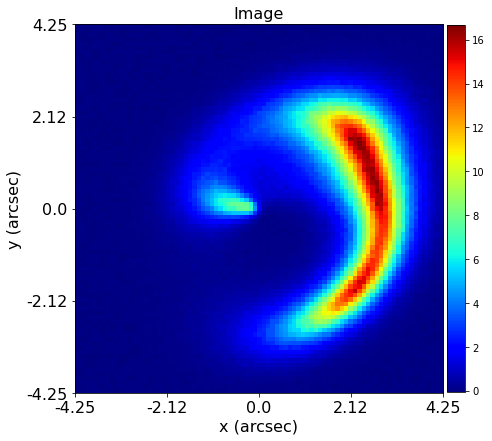

In [15]:
aplt.Imaging.image(imaging=imaging)

Finally, lets output these files to.fits files.

The data path specifies where the data is output, this time in the directory Test_1/Data’.


In [16]:
from pyprojroot import here

workspace_path = str(here())
dataset_path = f"{workspace_path}/Autolens_tests/autolens_workspace/Test_1/Data"
print("Dataset Path: ", dataset_path)

Dataset Path:  /home/carlos/Documents/GitHub/Master-Degree/Autolens_tests/autolens_workspace/Test_1/Data


In [17]:
imaging.output_to_fits(
    image_path=f"{dataset_path}/image.fits",
    noise_map_path=f"{dataset_path}/noise.fits",
    psf_path=f"{dataset_path}/psf.fits",
    overwrite=True,
)

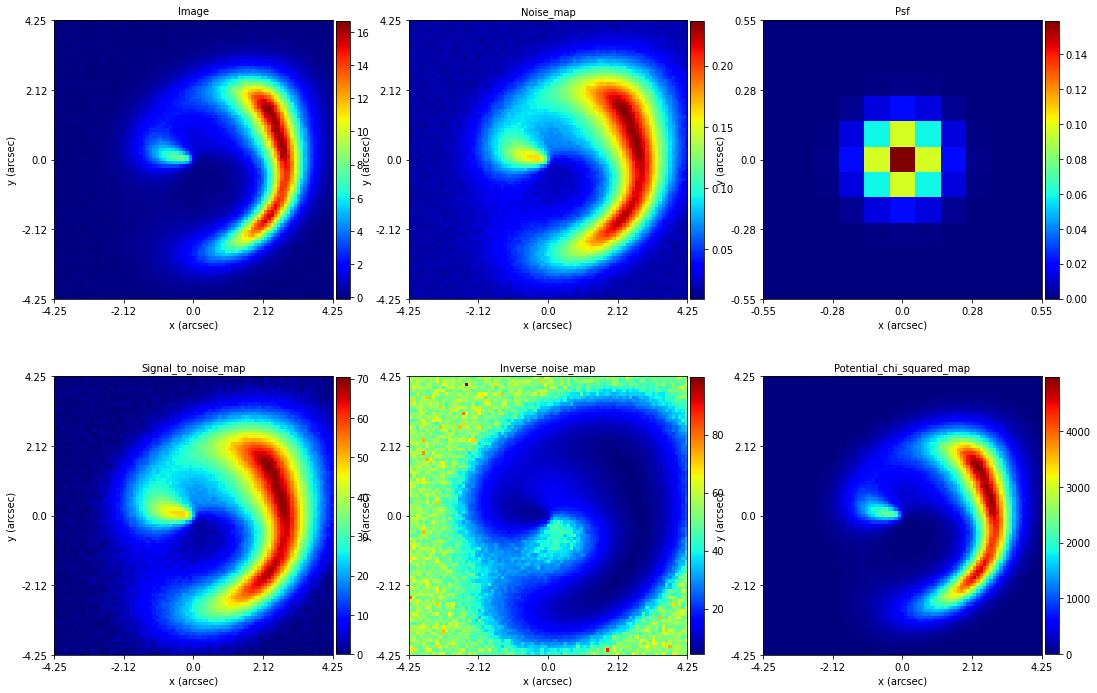

In [18]:
#Load data
imaging = al.Imaging.from_fits(
        image_path=f"{dataset_path}/image.fits",
        noise_map_path=f"{dataset_path}/noise.fits",
        psf_path=f"{dataset_path}/psf.fits",
        pixel_scales=0.1,
    )

aplt.Imaging.subplot_imaging(imaging)